## CNN Architecture Experiments

#### Current Optimised HyperParameters:
#### Layer 1 Kernel Size: 100 samples (1000 ns)
#### Layer 2 Kernel Size: 60 samples (600 ns)
#### Layer 1 Filters: 64
#### Layer 2 Filters: 154
#### Stride: 4
#### Pool Size: 3
#### Learning Rate: 5.76249e-04
#### Batch Size: 323

### Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
%matplotlib inline
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers, regularizers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, legacy
from tensorflow.keras.layers import Dropout, BatchNormalization
import seaborn as sn
import pandas as pd
import awkward as ak
import hist
from hist import Hist, axis
from sklearn.model_selection import train_test_split
from scipy.stats import binomtest
from sklearn.metrics import confusion_matrix

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
font = {'weight' : 'normal','size'   : 14}
plt.rc('font', **font)

# Load data from Parquet file and convert to strings
data_path = '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

# Normalising the Data


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

In [4]:
def normalise_array(arr):
    # Normalise each sub-array individually and return as an awkward array
    return ak.Array([
        (sub_array - np.min(sub_array)) / (np.max(sub_array) - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

def remove_array_offset(arr):
    # Normalise each sub-array individually and return as an awkward array
    return ak.Array([
        (sub_array - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

# Apply normalisation to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

unnormalised_times = remove_array_offset(arr['times']) # Unnormalised times but shifted to start at zero (offset remove)

print(f"Lengths of first few subarrays in normalised_times: {ak.num(normalised_times, axis=1)[:10]}")
print(f"Example subarray from normalised_times: {normalised_times[0]}")
print(f"Example subarray from unnormalised_times: {unnormalised_times[3654]}")


# Print minimum and length for testing
# print(f"Minimum values of sub-arrays: {[sub_array.min() for sub_array in padded_times]}")
# print(f"Length of sub-array 200: {len(padded_times[200])}")

Lengths of first few subarrays in normalised_times: [1101, 932, 525, 640, 656, 651, 635, 829, 356, 1236]
Example subarray from normalised_times: [0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.996, 0.997, 0.998, 0.999, 1]
Example subarray from unnormalised_times: [0, 10, 20, 30, 40, 50, ..., 7.51e+03, 7.52e+03, 7.53e+03, 7.54e+03, 7.55e+03]


# Standardising Length of Data

In [5]:
# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), mode='constant', constant_values=0) for sub_array in ak.to_list(array)]
        )
    )

print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))

times_lengths = ak.num(arr['times'], axis=1)
max_time_length = ak.max(times_lengths) # returns length of longest time series in dataset
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))
unnormalised_padded_times = np.array(pad_to_max_length(unnormalised_times, max_time_length))

sampling_interval_us = 0.01 # interval between consecutive samples in microseconds
time_us = [np.arange(len(wave)) * sampling_interval_us for wave in arr["times"]]
print(time_us[1036]) #TEST: the last element in this row should equal 18.3 µs

print(f"Length After Padding: {len(padded_times[0])}")
print(f"Length After Padding: {len(unnormalised_padded_times[3743])}")

Number of rows with unexpected or missing labels: 0
Number of NaN values in area column: 0
7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
[0.000e+00 1.000e-02 2.000e-02 ... 1.825e+01 1.826e+01 1.827e+01]
Length After Padding: 1828
Length After Padding: 1828


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

Now lets standardise the Sample data

In [6]:
print(len(arr['samples']))
print(f"Length Before Padding: {len(arr['samples'][0])}")
print("Structure of 'times':", ak.type(arr['samples']))

samples_lengths = ak.num(arr['times'], axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")
# print(padded_samples[0][-200:])

7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


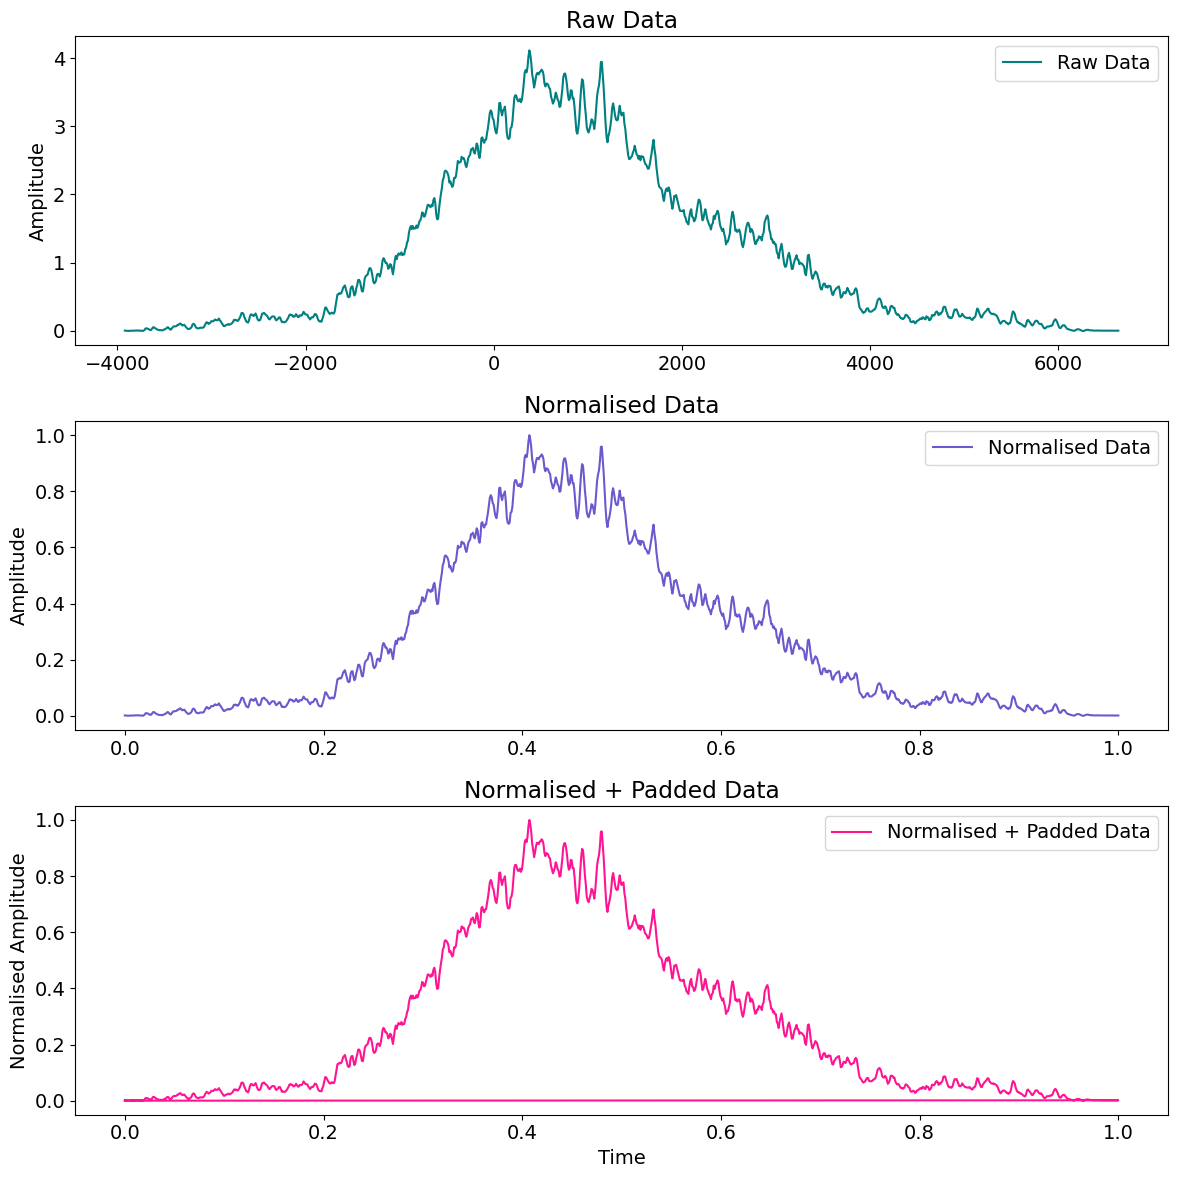

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))  # axs is an array of Axes

# Plot the first dataset in the first subplot
axs[0].plot(arr['times'][32], arr['samples'][32], label='Raw Data', color='teal')
axs[0].set_title("Raw Data")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Plot the second dataset in the first subplot
axs[1].plot(normalised_times[32], normalised_samples[32], label='Normalised Data', color='slateblue')
axs[1].set_title("Normalised Data")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

# Plot the third dataset in the second subplot
axs[2].plot(padded_times[32], padded_samples[32], label='Normalised + Padded Data', color='deeppink')
axs[2].set_title("Normalised + Padded Data")
axs[2].set_ylabel("Normalised Amplitude")
axs[2].legend()

# Add overall labels
plt.xlabel("Time")

# Adjust spacing between subplots for readability
plt.tight_layout()

# Show the plot
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/errorsinpaddingandnormalising.png')
plt.show()

# Creating the Training and Test Data (AwkwardArrays)

(7782, 2828)
(7782, 2828)


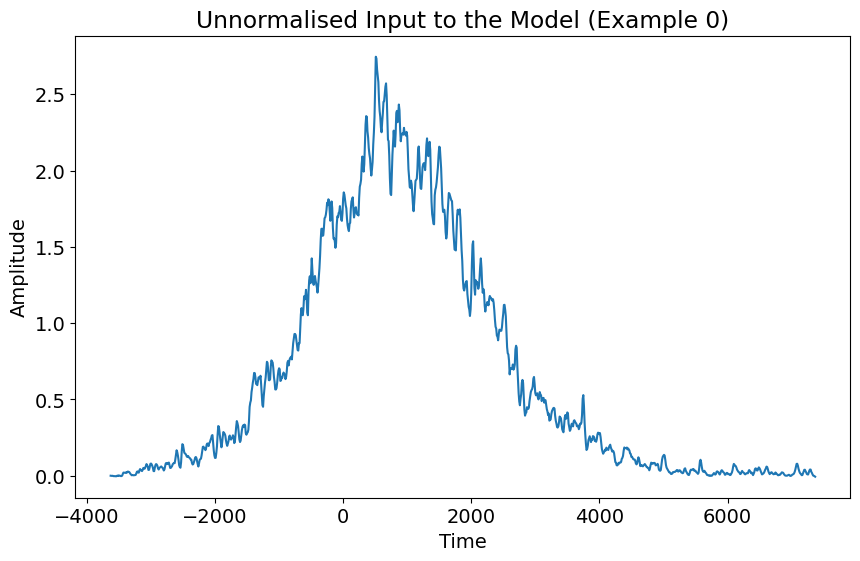

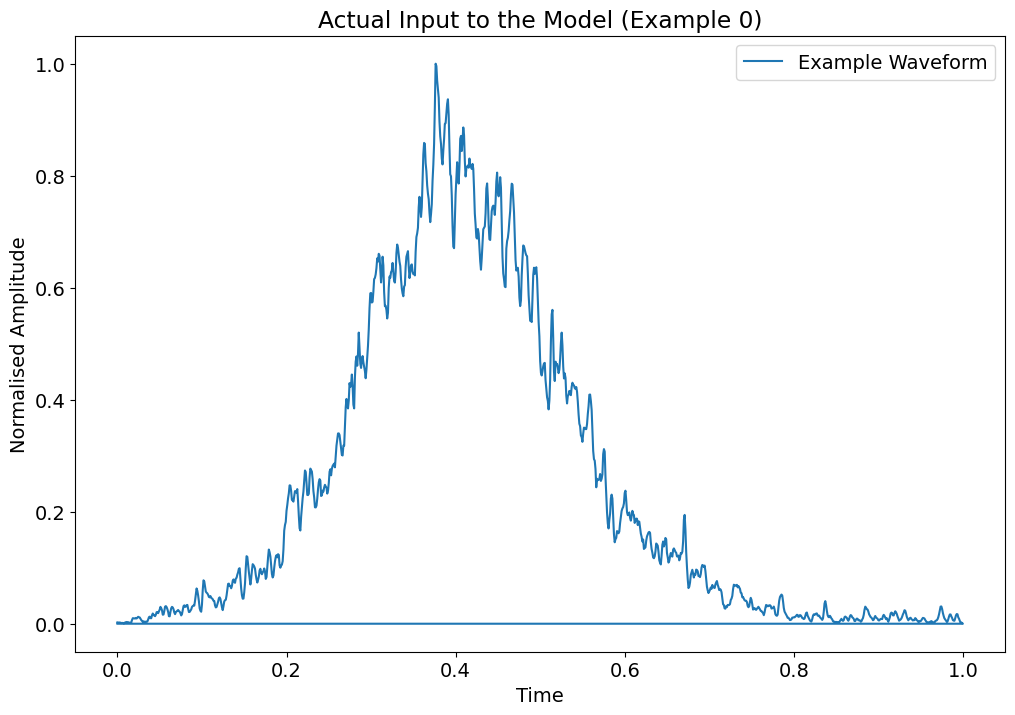

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Define padding length
padding_length = 500

# X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

# Add zero-padding on each side of the data (only along the time dimension for 2D data) Then reshape X_train_padded and X_test_padded to 3D
normalised_times_padded = np.pad(padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
unnormalised_times_padded = np.pad(unnormalised_padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
normalised_samples_padded = np.pad(padded_samples, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X = normalised_samples_padded
print(normalised_times_padded.shape)
print(X.shape)

time_steps = normalised_times_padded.shape[1]
example_index = 0
example_row = X[example_index]

# Split the row into time and samples
example_time = normalised_times_padded[example_index][500:-500]  # The time data of sample index {example_index}
example_samples = example_row[500:-500]  # The sample data of sample index {example_index}

plt.figure(figsize=(10, 6))
plt.plot(arr['times'][0], arr['samples'][0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title(f"Unnormalised Input to the Model (Example {example_index})")

plt.show()
plt.plot(example_time, example_samples, label="Example Waveform")
plt.xlabel("Time")
plt.ylabel("Normalised Amplitude")
plt.title(f"Actual Input to the Model (Example {example_index})")
plt.legend()
# plt.grid(True)
plt.show()

# S2 Area Spectrum

In [9]:
areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
gate_hist.fill(gate_events)

tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
tritium_hist.fill(tritium_events)

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01))
cathode_hist.fill(cathode_events)

print(tritium_hist.view())
print(gate_hist.view())
print(cathode_hist.view())

305.75293803418805
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   4.  14.  12.  33.  39.  49.  65.  67.  65.  76.  66.  93.  90.
  89. 109.  78. 105.  82. 109.  78.  96.  80. 101. 109.  96.  87.  95.
  95.  83.  86.  96.  84. 101.  82.  70.  79.  81.  78.  67.  96.  77.
  71.  70.  78.  67.  59.  67.  61.  59.  58.  58.  43.  53.  44.  55.
  60.  64.  52.  39.  53.  32.  33.  29.  47.  35.  41.  31.  29.  27.
  24.  37.  24.  23.  24.  19.  17.  18.  18.  15.   9.  21.  14.  26.
  16.   0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5. 13. 43.
 60. 42. 27. 25. 18. 25. 18. 16. 24. 23. 18. 41. 26. 21. 22. 22. 23. 15.
 22. 20. 19. 16. 19. 17. 15. 14. 13. 16. 17. 33. 11. 31. 11. 22. 19. 16.
 14. 18. 21. 24. 16. 17. 19. 18. 25. 24. 23. 27. 17. 32. 18. 23. 23. 17.
 20. 13. 19. 13. 18. 12. 15. 21. 16. 17. 19. 13. 23. 24. 21. 15. 22. 20.
 18. 32. 22. 12. 16. 13. 13. 19. 11.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 

In [10]:
bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
print(bin_edges[-2])

# Retrieve and adjust counts for each histogram
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers

print(cathode_hist.view().sum())
print(tritium_counts[-1])
print(gate_counts[-1])
print(cathode_counts[-1])

305.7223627403846
1189.0
0.0
0.0
0.0032545047259652992


# Weighting the S2 Area Spectrum

MAX areas: tritum,gate, cathode, overall dataset (17881.375, 17847.5546875, 17886.546875, 17886.546875)
13.411785247523326
37.54691093085141
10.274164346048565
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.4

/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_82741/1873441013.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_82741/1873441013.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_82741/1873441013.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_82741/1873441013.py:50: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /70 # * (average_counts / gate_counts.sum())
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipyke

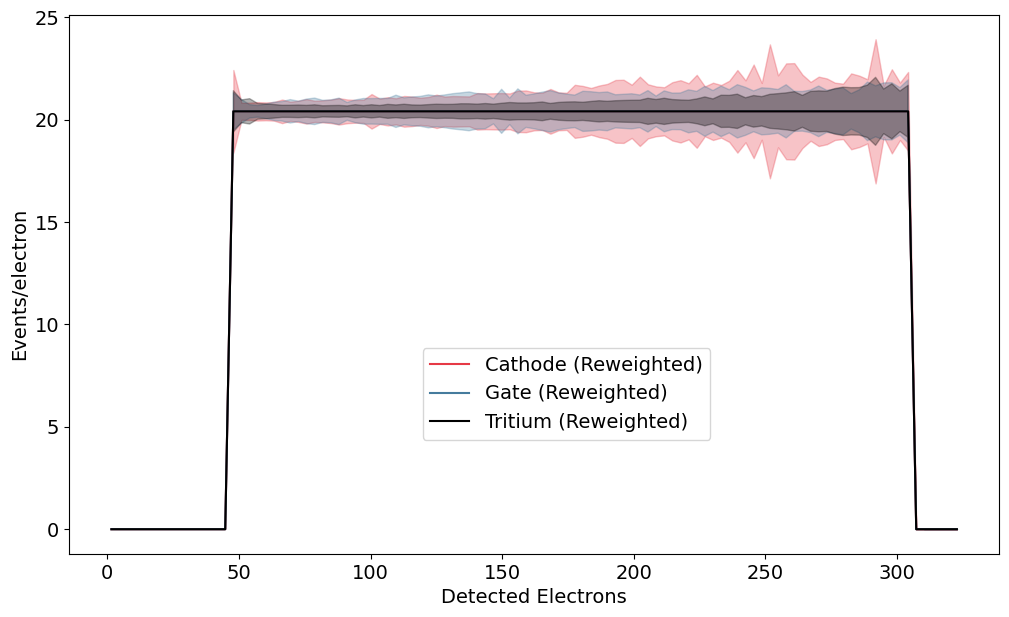

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

areas = arr['area']

max_tritium_area = max(areas[arr.label == 2])
max_gate_area = max(areas[arr.label == 1])
max_cathode_area = max(areas[arr.label == 0])
max_area = max(areas)
print(f'MAX areas: tritum,gate, cathode, overall dataset {max_tritium_area, max_gate_area, max_cathode_area, max_area}')

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 

print(gate_counts.sum()) # total area under the histogram (integral of histogram)
print(tritium_counts.sum()) # total area under the histogram (integral of histogram)
print(cathode_counts.sum()) # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()]) # average integral (area) of each histgoram to be used as reweighting benchmark

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))

tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] > cathode_counts[-1] else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)

#tritium_reweighted[-1] = 37.92238004
cathode_reweighted = np.array(cathode_reweighted)

print(gate_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /70 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /70 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/70 # * (average_counts / cathode_counts.sum())

# PADDING: Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='#E63946', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='#E63946', alpha=0.3
)

# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='#457B9D', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='#457B9D', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='black', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='black', alpha=0.3
)

ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(0.7,0.4),loc='upper right',frameon=True,fontsize=14) 
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/HE_weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating the Weight Array to Feed into CNN

In [12]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights) # check if values are defined (finite), 0 if not.

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)

#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))

these are da 100
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782


# Creating and Populating the New Weight Column in the Main Dataframe

In [13]:
weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

4882


# Optional Code: Normalising the Weights Array

In [14]:
num_events = len(arr['weights'])
total_weight = ak.sum(arr['weights'])
mean_weight = total_weight / num_events
weights_mean_one = arr['weights'] / mean_weight # rescale all weights to have a mean of 1.
arr = ak.with_field(arr, weights_mean_one, 'weights_normalised')
print(arr['weights_normalised'])

[4.23, 0.18, 1.1, 1.1, 1.1, 1.1, 1.1, ..., 6.14, 6.14, 6.14, 6.14, 6.14, 6.14]


# Experiment 1: 2 FCs instead of 1?

In [15]:
seed_value = 42 # set a global random seed for model reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

weights_np = ak.to_numpy(arr['weights'])
normalised_weights_np = ak.to_numpy(arr['weights_normalised'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalised_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']

radii = ak.to_numpy(arr['r'])

# TO ALTER BETWEEN WEIGHTS AND NORMLAISED WEIGHTS> CHANGE WEIGHTS_NP VARIABLE ACCORDINGLY> DEFAULT: NORMALISED WEIGHTS
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test, \
normalised_times_train, normalised_times_test, times_us_train, times_us_test, \
normalised_samples_train, normalised_samples_test, r_train, r_test = train_test_split(
    X, labels, normalised_area, normalised_weights_np, normalised_times, time_us, normalised_samples, radii, 
    test_size=0.25, random_state=42
)

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)

y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test)
print("Shape of y_train:", y_train.shape)

y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

X_train_padded = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # adding a channels dimension (greyscale of 1) to enable seamless input into CNN
X_test_padded = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_test_padded.shape)

7782
Length of X_train: 5836
Length of y_train: 5836
Length of weights_train: 5836
Shape of weights_train: (5836,)
Shape of X_train: (5836, 2828)
Shape of y_train: (5836,)
(1946, 2828, 1)


Smaller kernels in early layers capture local, fine-grained features (like edges or small peaks in your waveforms), while larger kernels in deeper layers can aggregate these to detect more complex patterns.
Smaller kernels in early layers (where the input has higher resolution/more time steps) also help to reduce computational load. Lastly, Even with small kernels, deeper layers naturally have a smaller effective receptive field due to the cumulative effect of convolutions through the network hence making it natural for deeper conv layers to have smaller kernels.

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    min_delta=0.01,      # Minimum change in loss to qualify as an improvement
    patience=3,          # Stop training after 3 epochs of no significant improvement
    verbose=1,           # Print a message when stopping
    restore_best_weights=True  # Restore the weights from the best epoch
)
# Custom Stochastic Dropout layer
class StochasticDropout(layers.Layer):
    def __init__(self, mean_rate=0.2, stddev=0.1, **kwargs):
        self.mean_rate = mean_rate  # Mean dropout rate
        self.stddev = stddev        # Standard deviation of dropout rate
        self.supports_masking = True
        super(StochasticDropout, self).__init__(**kwargs)
        
    def call(self, inputs, training=None):
        if training:
            # Sample dropout rate from normal distribution
            dropout_rate = np.random.normal(self.mean_rate, self.stddev)
            # Clip to ensure valid range between 0 and 1
            dropout_rate = np.clip(dropout_rate, 0.0, 0.9)
            
            # Apply dropout with the sampled rate
            return tf.nn.dropout(inputs, rate=dropout_rate)
        return inputs
    
    def get_config(self):
        config = {'mean_rate': self.mean_rate, 'stddev': self.stddev}
        base_config = super(StochasticDropout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# First, define the DropBlock1D implementation
class DropBlock1D(tf.keras.layers.Layer):
    """DropBlock1D: A structured form of dropout for 1D inputs.
    
    Args:
        keep_prob: Probability of keeping a unit active (1 - drop_probability).
        block_size: Size of the contiguous segment to drop.
    """
    
    def __init__(self, keep_prob=0.8, block_size=5, **kwargs):
        super(DropBlock1D, self).__init__(**kwargs)
        self.keep_prob = keep_prob
        self.block_size = block_size
    
    def get_config(self):
        config = super(DropBlock1D, self).get_config()
        config.update({
            'keep_prob': self.keep_prob,
            'block_size': self.block_size,
        })
        return config
        
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def build(self, input_shape):
        self.input_shape_tensor = tf.constant(input_shape.as_list())
        _, self.seq_length, self.channels = input_shape.as_list()
        
        # Compute gamma - the drop probability for the raw 1D feature map
        self.block_size_float = tf.cast(self.block_size, tf.float32)
        self.gamma = (1. - self.keep_prob) * self.seq_length / self.block_size / \
                     (self.seq_length - self.block_size + 1)
        
        super(DropBlock1D, self).build(input_shape)
    
    def call(self, inputs, training=None):
        if training:
            return self._drop_block(inputs)
        else:
            return inputs
    
    def _drop_block(self, inputs):
        # Get the shape of input tensor
        batch_size = tf.shape(inputs)[0]
        
        # Calculate the seed length (where we can place the start of a block)
        seed_length = self.seq_length - self.block_size + 1
        
        # Generate mask
        uniform_noise = tf.random.uniform(
            shape=[batch_size, seed_length, self.channels],
            minval=0, maxval=1)
        
        # Binarize the noise based on gamma threshold
        gamma = tf.cast(self.gamma, dtype=tf.float32)
        binary_mask = tf.cast(uniform_noise < gamma, dtype=tf.float32)
        
        # Create block mask by dilating with block_size
        block_mask = tf.nn.max_pool1d(
            binary_mask,
            ksize=self.block_size,
            strides=1,
            padding='SAME')
        
        # Convert to binary mask
        block_mask = 1 - tf.cast(tf.greater(block_mask, 0), dtype=tf.float32)
        
        # Apply the mask
        block_mask = tf.cast(block_mask, dtype=inputs.dtype)
        
        # Scale the output to maintain the expected value
        scale = tf.cast(tf.size(block_mask), dtype=tf.float32) / tf.reduce_sum(block_mask)
        return inputs * block_mask * scale


# Build the model with DropBlock1D instead of standard Dropout
convoNN = tf.keras.Sequential([
    # First 1D convolution layer
    layers.Conv1D(filters=64, kernel_size=100, activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(X_train_padded.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    # Replace Dropout with DropBlock1D (keep_prob=0.8 is equivalent to dropout rate of 0.2)
    DropBlock1D(keep_prob=0.8, block_size=7),
    
    # Second 1D convolution layer
    layers.Conv1D(filters=154, kernel_size=60, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer
    layers.Flatten(),
    
    # Dense layers
    layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    
    # Output layer
    layers.Dense(3, activation='softmax')
])

# Compile the model
optimizer = legacy.Adam(learning_rate=5.762e-4)
convoNN.compile(optimizer=optimizer, 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

# Model summary to verify the architecture
convoNN.summary()

#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 64 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2) specifies a pooling window which means the layer will take the max value from every 2-linear-unit-wide region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons

history = convoNN.fit(X_train_padded, y_train, sample_weight=weights_train, epochs=10, batch_size=323, validation_split=0.2, verbose=0)
convoNN.evaluate(X_test_padded, y_test, verbose=1)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

## Model Evaluation on Test Data

61/61 [==============================] - 12s 189ms/step - loss: 0.2821 - accuracy: 0.8859


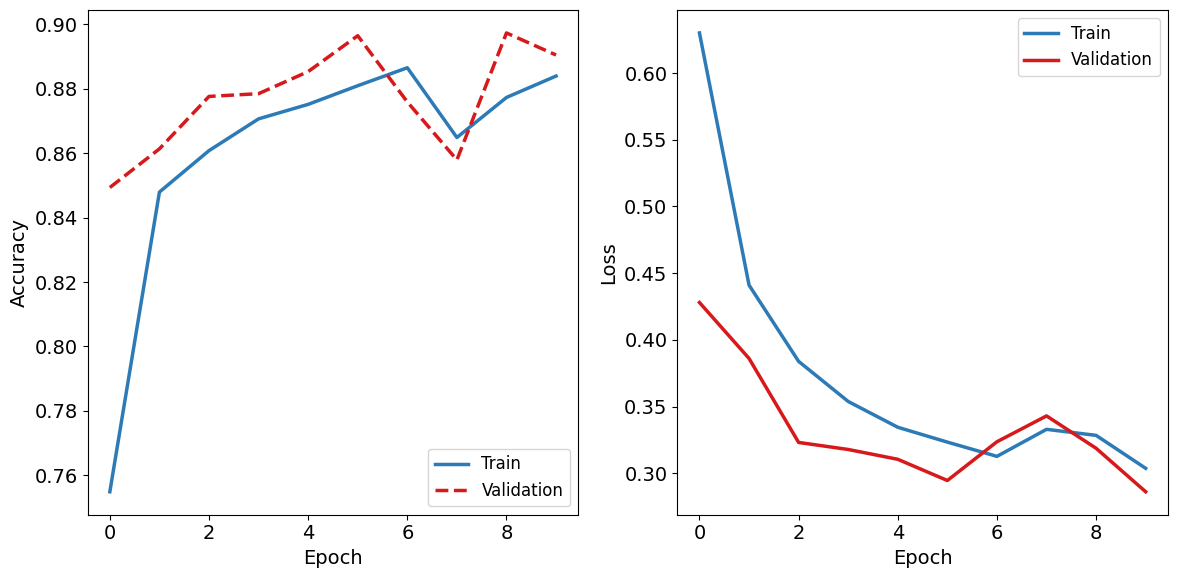

In [ ]:
convoNN.evaluate(X_test_padded, y_test, verbose=1) # tf.model.evaluate() will return a list (or tuple) with two numbers: 
# The first number is the loss computed on the test set (using sparse categorical crossentropy).
# The second number is the accuracy computed on the test set.


# Testing for overfitting with better colors
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='#2C7BB6', linewidth=2.5, label='Train')
plt.plot(history.history['val_accuracy'], color='#D7191C', linewidth=2.5, linestyle='--', label='Validation')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='#2C7BB6', linewidth=2.5, label='Train')
plt.plot(history.history['val_loss'], color='#D7191C', linewidth=2.5, label='Validation')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/StochasticDropoutExperiment_HE_training_validation_loss.png', dpi=1800)
plt.show()

# Experiment 2: Batch Normalisation + Later Dropout?

In [ ]:
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitor the validation loss
#     min_delta=0.01,      # Minimum change in loss to qualify as an improvement
#     patience=3,          # Stop training after 3 epochs of no significant improvement
#     verbose=1,           # Print a message when stopping
#     restore_best_weights=True  # Restore the weights from the best epoch
# )

# convoNN_batch = keras.Sequential([
#     # First 1D convolution layer
#     keras.layers.Conv1D(filters=64, kernel_size=100, padding='same', input_shape=(X_train_padded.shape[1], 1)),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'),
#     keras.layers.MaxPooling1D(pool_size=2), 
#     Dropout(0.3),  
    
#     # Second 1D convolution layer
#     keras.layers.Conv1D(filters=154, kernel_size=60, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Activation('relu'), 
#     keras.layers.MaxPooling1D(pool_size=2),
#     Dropout(0.2),
    
#     # Flatten layer to connect to dense layers. 2D pooled feauture map flattened to 1D vector to input into dense outer layers.
#     keras.layers.Flatten(),
#     # 1 FC Layer
#     keras.layers.Dense(96, activation='relu'),
#     keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
# ])

# # Compile the model
# optimizer = legacy.Adam(learning_rate=5.762e-4)
# convoNN_batch.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# #CNN with 7 layers
# #the first two Conv2D extract spatial features from the image- i.e. there will be 64 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
# #max Pooling layer performs down-sampling to resduce spatial dimensions
# #(2) specifies a pooling window which means the layer will take the max value from every 2-linear-unit-wide region
# #flatten layer converts information from 2D map to a 1D vector
# #64 layer is a dense layer with 64 neurons

# history_batch = convoNN_batch.fit(X_train_padded, y_train, sample_weight=weights_train, epochs=10, batch_size=323, validation_split=0.2, verbose=0)
# convoNN_batch.evaluate(X_test_padded, y_test, verbose=1)

# Experiment 3: Learning Rate Schedule?

In [ ]:
# from tensorflow.keras.callbacks import LearningRateScheduler

# # Define different learning rate schedules to test

# # 1. Step decay schedule
# def step_decay(epoch, initial_lr=5.762e-4, drop=0.5, epochs_drop=2):
#     return initial_lr * (drop ** np.floor((1 + epoch) / epochs_drop))

# # 2. Exponential decay schedule
# def exp_decay(epoch, initial_lr=5.762e-4, k=0.1):
#     return initial_lr * np.exp(-k * epoch)

# # 3. Time-based decay
# def time_decay(epoch, initial_lr=5.762e-4):
#     return initial_lr / (1 + 0.1 * epoch)

# # 4. Cosine annealing
# def cosine_decay(epoch, initial_lr=5.762e-4, epochs=10):
#     return initial_lr * (1 + np.cos(np.pi * epoch / epochs)) / 2

# # Create a list of schedule names and functions to test
# schedules = [
#     ("Constant LR", lambda epoch: 5.762e-4),
#     ("Step Decay", step_decay),
#     ("Exponential Decay", exp_decay),
#     ("Time-based Decay", time_decay),
#     ("Cosine Annealing", cosine_decay)
# ]

# # Store results
# results = []

# # Run experiment for each schedule
# for name, schedule_fn in schedules:
#     print(f"\nTraining with {name} learning rate schedule...")
    
#     # Create a fresh model for each experiment
#     model = keras.Sequential([
#         # First 1D convolution layer
#         keras.layers.Conv1D(filters=64, kernel_size=100, activation='relu', padding='same', input_shape=(X_train_padded.shape[1], 1)),
#         keras.layers.MaxPooling1D(pool_size=2),
#         Dropout(0.3),
        
#         # Second 1D convolution layer
#         keras.layers.Conv1D(filters=154, kernel_size=60, padding='same', activation='relu'),
#         keras.layers.MaxPooling1D(pool_size=2),
        
#         # Flatten layer
#         keras.layers.Flatten(),
        
#         # Multiple FC layers
#         keras.layers.Dense(96, activation='relu'),
        
#         # Output layer
#         keras.layers.Dense(3, activation='softmax')
#     ])
    
#     # Create the learning rate scheduler callback
#     lr_scheduler = LearningRateScheduler(schedule_fn)
    
#     # Compile the model with Adam optimizer (initial learning rate doesn't matter as it will be scheduled)
#     model.compile(
#         optimizer=tf.keras.optimizers.legacy.Adam(),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
#     # Train the model
#     history = model.fit(
#         X_train_padded, y_train,
#         sample_weight=weights_train,
#         epochs=5,
#         batch_size=323,
#         validation_split=0.2,
#         callbacks=[lr_scheduler, early_stopping],
#         verbose=1
#     )
    
#     # Evaluate the model
#     test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=1)
#     print(f"{name} Test Accuracy: {test_acc:.4f}")
    
#     # Store results
#     results.append({
#         'name': name,
#         'history': history.history,
#         'test_accuracy': test_acc,
#         'test_loss': test_loss
#     })

# # Plot the learning curves for each schedule
# plt.figure(figsize=(15, 10))

# # Plot training & validation accuracy
# plt.subplot(2, 1, 1)
# for result in results:
#     plt.plot(result['history']['accuracy'], label=f"{result['name']} (Train)")
#     plt.plot(result['history']['val_accuracy'], linestyle='--', 
#              label=f"{result['name']} (Val)")
# plt.title('Model Accuracy for Different Learning Rate Schedules')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend()

# # Plot training & validation loss
# plt.subplot(2, 1, 2)
# for result in results:
#     plt.plot(result['history']['loss'], label=f"{result['name']} (Train)")
#     plt.plot(result['history']['val_loss'], linestyle='--', 
#              label=f"{result['name']} (Val)")
# plt.title('Model Loss for Different Learning Rate Schedules')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Plot the learning rate over epochs for each schedule
# plt.figure(figsize=(10, 6))
# for name, schedule_fn in schedules:
#     lr_values = [schedule_fn(i) for i in range(10)]  # Calculate LR for 10 epochs
#     plt.plot(range(10), lr_values, label=name)
# plt.title('Learning Rate Schedules')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Print a summary of results
# print("\nSummary of Test Accuracies:")
# for result in results:
#     print(f"{result['name']}: {result['test_accuracy']:.4f}")

# Visualising the Model Classification Effectiveness: The Probability Distribution

61/61 [==============================] - 11s 178ms/step


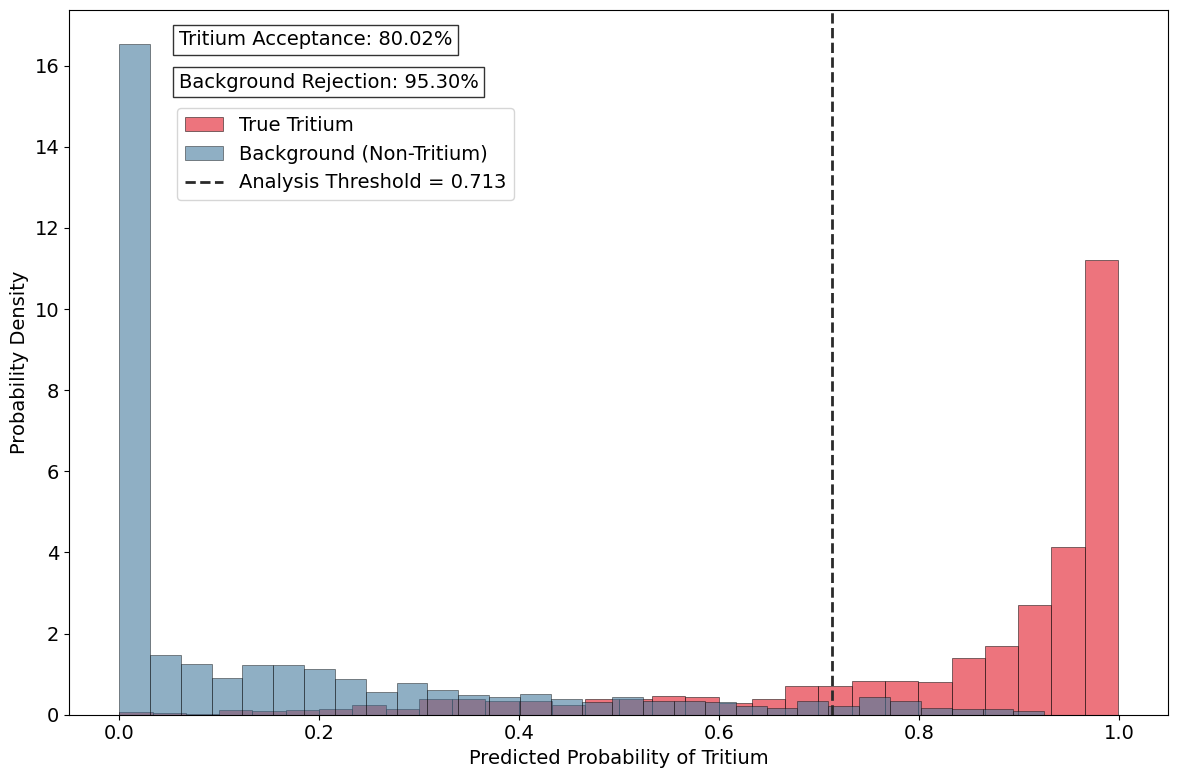

In [ ]:
# Step 1: Get predicted probabilities for each class
y_pred_proba = convoNN.predict(X_test_padded)
predicted_classes = np.argmax(y_pred_proba, axis=1)

# Step 2: Calculate background and bulk probabilities
background_proba = y_pred_proba[:, 0] + y_pred_proba[:, 1]  # Sum of Gate and Cathode probabilities
bulk_proba = y_pred_proba[:, 2]  # Tritium probabilities

# Separate true Tritium events from non-Tritium events
true_tritium_mask = (y_test == 2)  # actual tritium events
non_tritium_mask = (y_test != 2)  # non-tritium(background) events

# Find threshold at 20th percentile of true Tritium probabilities
threshold = np.percentile(bulk_proba[true_tritium_mask], 20)

# Step 3: Plot normalized histograms with better styling
plt.figure(figsize=(12, 8))

# Histogram for actual Tritium events - normalized with density=True
plt.hist(bulk_proba[true_tritium_mask], bins=30, alpha=0.7, 
         color='#E63946', label='True Tritium', density=True,
         edgecolor='black', linewidth=0.5)

# Histogram for non-Tritium events - also normalized
plt.hist(bulk_proba[non_tritium_mask], bins=30, alpha=0.6, 
         color='#457B9D', label='Background (Non-Tritium)', density=True,
         edgecolor='black', linewidth=0.5)

# Add threshold line with improved styling
plt.axvline(x=threshold, color='#2A2A2A', linestyle='--', linewidth=2,
           label=f'Analysis Threshold = {threshold:.3f}')

# Calculate acceptance and rejection rates for display in the legend
tritium_acceptance = np.mean(bulk_proba[true_tritium_mask] >= threshold)
background_rejection = np.mean(bulk_proba[non_tritium_mask] < threshold)

# Add statistics to plot
plt.text(0.1, 0.95, f"Tritium Acceptance: {tritium_acceptance:.2%}", 
         transform=plt.gca().transAxes, fontsize=14, 
         bbox=dict(facecolor='white', alpha=0.8))
plt.text(0.1, 0.89, f"Background Rejection: {background_rejection:.2%}", 
         transform=plt.gca().transAxes, fontsize=14,
         bbox=dict(facecolor='white', alpha=0.8))

# Better styling for labels and legend
plt.xlabel('Predicted Probability of Tritium', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=[0.098, 0.73], fontsize=14)

# Add tight layout for better spacing
plt.tight_layout()

plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/HE_probability_histogram.png', dpi=1800)
plt.show()

## Figure 7 (LUX-LOWMASS) Production
### We use Clopper-Pearson Confidence Intervals in our Error Propagation

The probability threshold corresponding to 80% of the tritium data lying after that line is 0.713


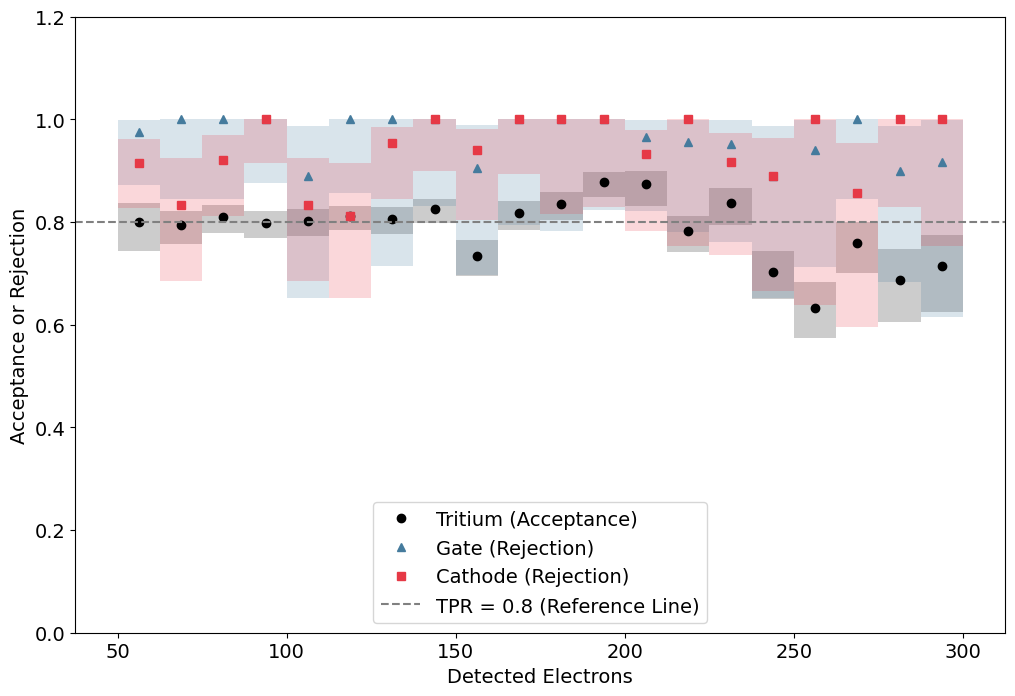

In [ ]:
# Increase the number of bins for more points in the scatter plot
num_bins = 20 # Adjust this number to make the bins smaller and create more points

print(f"The probability threshold corresponding to 80% of the tritium data lying after that line is {threshold:.3f}")

bin_edges = np.linspace(50, 300, num_bins + 1)  # Uniform bins between 50 and 300

# Placeholder for storing acceptance values
# Placeholder for storing acceptance and rejection values
tritium_acceptance = []
gate_rejection = []
cathode_rejection = []
tritium_error = []
gate_error = []
cathode_error = []

# Function to calculate bin widths
def calculate_bin_widths(bin_edges):
    return bin_edges[1] - bin_edges[0]

# Loop through each bin
for i in range(len(bin_edges) - 1):
    # Define bin range
    lower, upper = bin_edges[i], bin_edges[i + 1]
    bin_center = (lower + upper) / 2
    bin_width = calculate_bin_widths(bin_edges)  # Dynamic bin width

    # Filter data points within the current bin
    mask = (area_test_np >= lower) & (area_test_np < upper)
    
    if np.any(mask):  # Skip bins with no data points
        # Extract data points for Tritium, Gate, and Cathode
        tritium_mask = mask & (y_test_np == 2)
        gate_mask = mask & (y_test_np == 1)
        cathode_mask = mask & (y_test_np == 0)

        # Calculate acceptance for Tritium
        tritium_proba = y_pred_proba[tritium_mask, 2]
        if len(tritium_proba) > 0:  # Ensure there are Tritium samples
           # dynamic_threshold = np.percentile(tritium_proba, 20)  # 20th percentile threshold for this bin
            accepted_tritium = np.sum(tritium_proba >= threshold)  # Count Tritium points above threshold
            total_tritium = len(tritium_proba)
            tritium_acceptance.append((bin_center, accepted_tritium / total_tritium))  # Normalise by true Tritium count

            ci = binomtest(accepted_tritium, total_tritium).proportion_ci(confidence_level=0.95)
            lower_error = (accepted_tritium / total_tritium) - ci.low
            upper_error = ci.high - (accepted_tritium / total_tritium)
            tritium_error.append((lower_error, upper_error)) # append confidence interval tuples to tritium_error array.
            # error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            # tritium_error.append(min(error,1))
        else:
            tritium_acceptance.append((bin_center, 0))  # No Tritium events in this bin
            tritium_error.append((0, 0))

        # Calculate rejection rates for Gate and Cathode
        gate_proba = y_pred_proba[gate_mask, 2]
        if len(gate_proba) > 0:
            rejected_gate = np.sum(gate_proba <= threshold)  # true negatives (in terms of actual signal events) for Gate
            total_gate = len(gate_proba)
            gate_rejection.append((bin_center, (rejected_gate / total_gate)))  # Normalise by true Gate count

            ci = binomtest(rejected_gate, total_gate).proportion_ci(confidence_level=0.95)
            lower_error = (rejected_gate / total_gate) - ci.low
            upper_error = ci.high - (rejected_gate / total_gate)
            gate_error.append((lower_error, upper_error))
            # error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            # gate_error.append(min(error,1))
        else:
            gate_rejection.append((bin_center, 0))
            gate_error.append((0, 0))

        cathode_proba = y_pred_proba[cathode_mask, 2]
        if len(cathode_proba) > 0:
            rejected_cathode = np.sum(cathode_proba <= threshold)  # true negatives (in terms of actual signal events) for Cathode
            total_cathode = len(cathode_proba)
            cathode_rejection.append((bin_center, (rejected_cathode) / total_cathode))  # Normalise by true Cathode count

            ci = binomtest(rejected_cathode, total_cathode).proportion_ci(confidence_level=0.95)
            lower_error = (rejected_cathode / total_cathode) - ci.low
            upper_error = ci.high - (rejected_cathode / total_cathode)
            cathode_error.append((lower_error, upper_error))
            # error = (np.sqrt(rejected_cathode) / total_cathode) * 0.3
            # cathode_error.append(min(error,1))
        else:
            cathode_rejection.append((bin_center, 0))
            cathode_error.append((0, 0))

# Convert collected points into arrays for plotting
tritium_x, tritium_y = zip(*tritium_acceptance)
gate_x, gate_y = zip(*gate_rejection)
cathode_x, cathode_y = zip(*cathode_rejection)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot Tritium acceptance with filled error bars
for x, y, (lower_error, upper_error) in zip(tritium_x, tritium_y, tritium_error):
    lower_bound = y - (lower_error)*0.3
    upper_bound = y + (upper_error) *0.3
    plt.plot(x, y, 'o', color='black', label='Tritium (Acceptance)' if x == tritium_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='black', alpha=0.2, linewidth=0)

# Plot Gate rejection with filled error bars
for x, y, (lower_error, upper_error) in zip(gate_x, gate_y, gate_error):
    lower_bound = y - lower_error
    upper_bound = y + upper_error
    plt.plot(x, y, '^', color='#457B9D', label='Gate (Rejection)' if x == gate_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='#457B9D', alpha=0.2, linewidth=0)

# Plot Cathode rejection with filled error bars
for x, y, (lower_error, upper_error) in zip(cathode_x, cathode_y, cathode_error):
    lower_bound = y - (lower_error) * 0.6
    upper_bound = y + (upper_error) * 0.7
    plt.plot(x, y, 's', color='#E63946', label='Cathode (Rejection)' if x == cathode_x[0] else "")
    plt.fill_between([x - bin_width / 2, x + bin_width / 2], lower_bound, upper_bound, color='#E63946', alpha=0.2, linewidth=0)

# Add reference line and other plot elements
plt.axhline(y=0.8, color='gray', linestyle='--', label='TPR = 0.8 (Reference Line)')
plt.ylim(0, 1.2)

plt.xlabel("Detected Electrons", fontsize=14)
plt.ylabel("Acceptance or Rejection", fontsize=14)
plt.legend(loc='lower center', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title("Acceptance and Rejection Rates with Confidence Intervals")
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/HE_Fig7.png', dpi=1800)
plt.show()

# Confusion Matrix

61/61 [==============================] - 11s 175ms/step


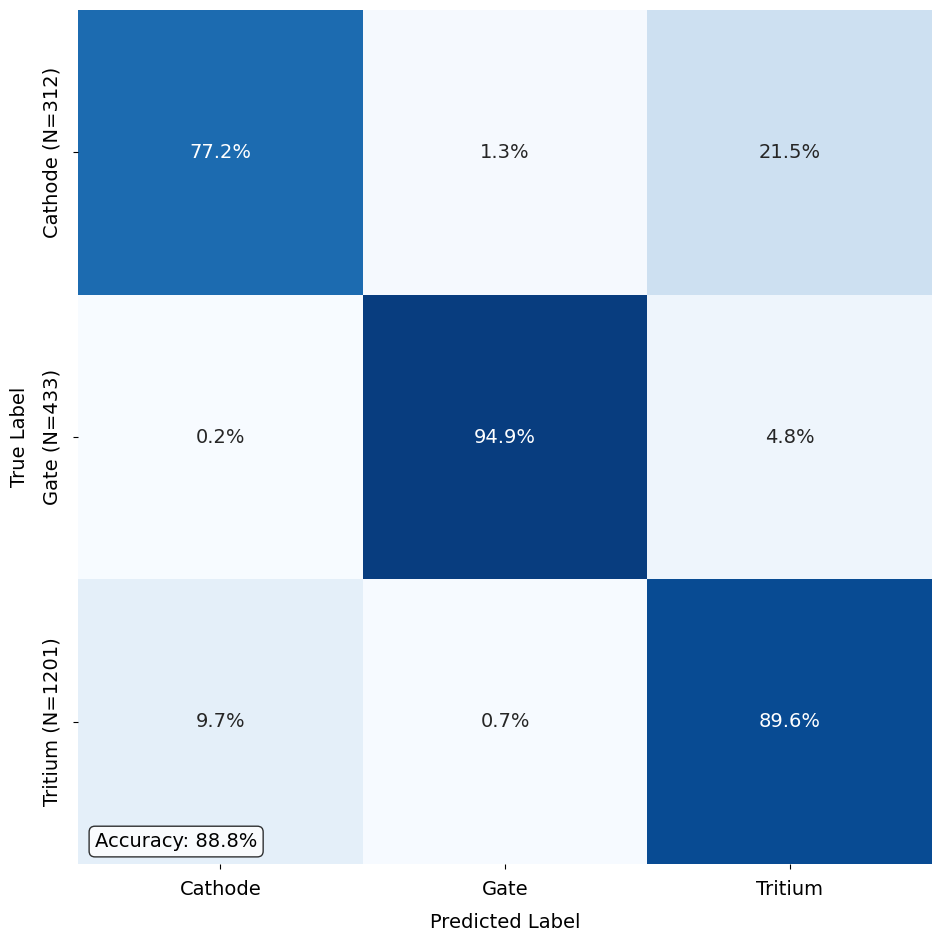

In [ ]:
def plot_normalised_confusion_matrix(y_true, y_pred, class_names=['Cathode', 'Gate', 'Tritium']):
    """
    Plot a normalised confusion matrix showing percentages of each true class.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    class_names : list
        Names of the classes
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a figure with custom size
    plt.figure(figsize=(14, 10))
    
    # Calculate the row totals (total per class)
    row_totals = cm.sum(axis=1)
    
    # Create percentage matrix for the heatmap colors
    cm_percent = np.zeros_like(cm, dtype=float)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cm_percent[i, j] = (cm[i, j] / row_totals[i]) * 100 if row_totals[i] > 0 else 0
    
    # Create annotation strings with percentages
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = (cm[i, j] / row_totals[i]) * 100 if row_totals[i] > 0 else 0
            annot[i, j] = f"{percentage:.1f}%"
    
    # Plot the heatmap with percentage values (no colorbar)
    ax = sn.heatmap(cm_percent, annot=annot, fmt='s', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names,
                   vmin=0, vmax=100, square=True, cbar=False, annot_kws={"fontsize": 14})
    
    # Improve the appearance
    ax.set_xlabel('Predicted Label', fontsize=14, labelpad=10)
    ax.set_ylabel('True Label', fontsize=14, labelpad=10)
    
    # Set fontsize for tick labels and move them away from the plot
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    
    # Add class totals to the tick labels with enough padding
    new_labels = [f"{name} (N={total})" for name, total in zip(class_names, row_totals)]
    ax.set_yticklabels(new_labels, fontsize=14, rotation=90)
    ax.set_xticklabels(class_names, fontsize=14)
    
    # Add a text box with overall accuracy
    accuracy = np.sum(np.diag(cm)) / np.sum(cm) * 100
    plt.text(0.02, 0.02, f"Accuracy: {accuracy:.1f}%",
             transform=ax.transAxes, fontsize=14,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add padding around the plot
    plt.tight_layout(pad=2.0)
    
    return ax

y_pred = np.argmax(convoNN.predict(X_test_padded), axis=1)

# Plot the confusion matrix
plot_normalised_confusion_matrix(y_test_np, y_pred)
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/confusion_matrix.png', dpi=1800)
plt.show()

# Visualising the Inputs to the Model

2828
(5836,)
2828
1828
2328


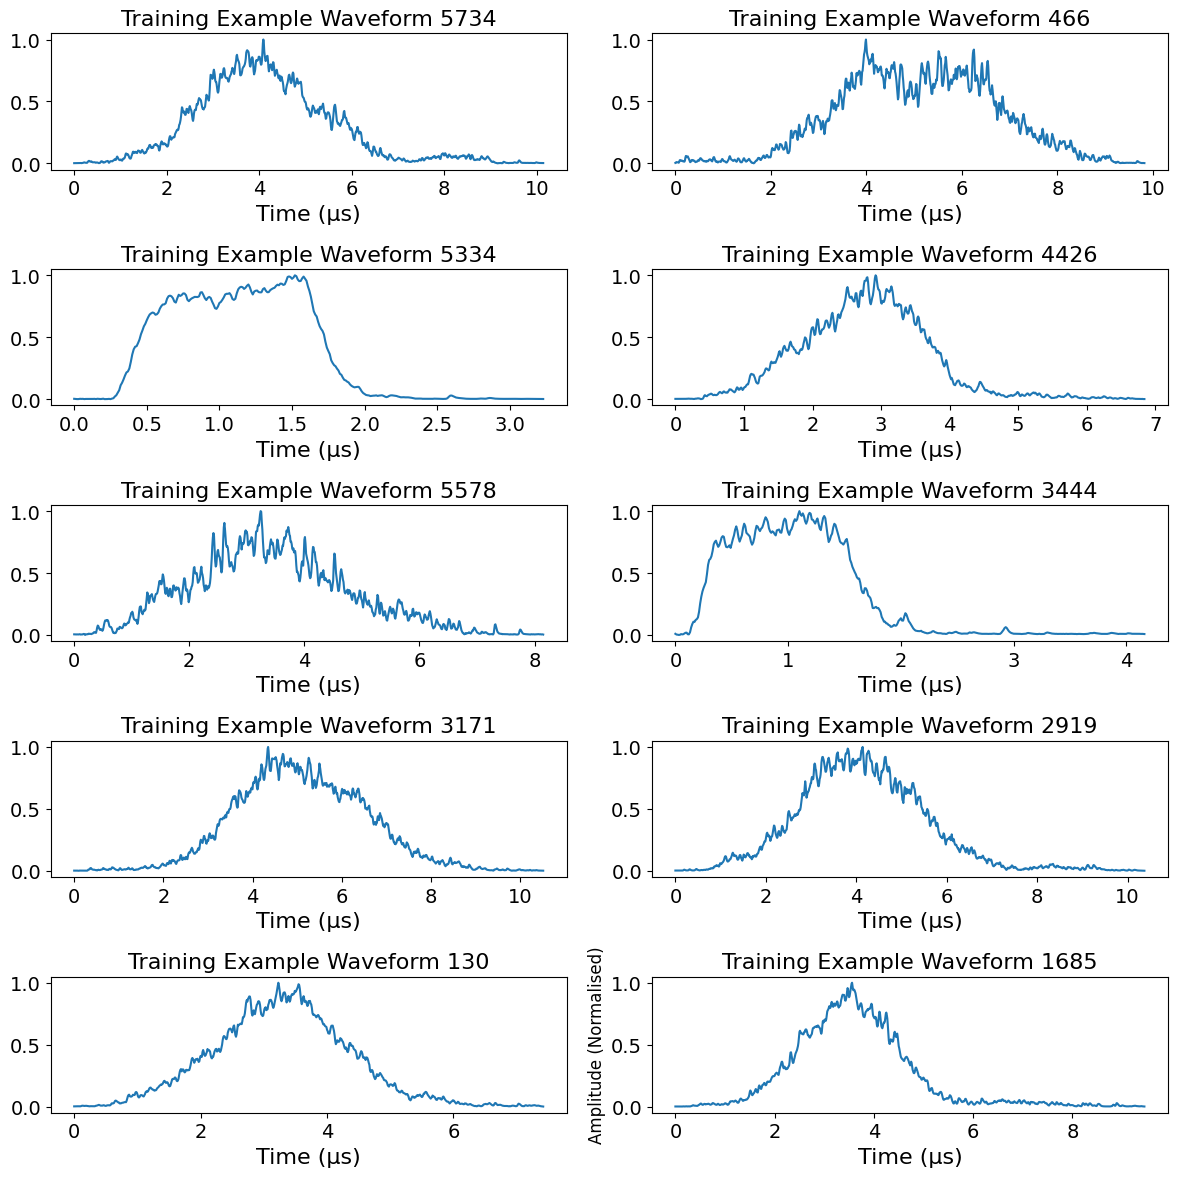

In [ ]:
from tensorflow.keras.models import Model
print(X_train_padded.shape[1])
print(y_train.shape)

# Select every 10^2-th waveform
step = 100  # Step size for selection
waveforms_to_plot = X_train_padded[::step]

num_samples = X_train_padded.shape[1]
print(num_samples)

# Calculate sample length before padding
original_time_sample_length = (num_samples - (2 * padding_length)) #// 2 # floor division (round down to nearest integer)
print(original_time_sample_length)
print(original_time_sample_length + (padding_length))

# Visualise the first 10 padded training examples
# Generate 10 random indices to plot 10 random examples
random_indices = np.random.randint(0, len(normalised_samples_train), size=10)

plt.figure(figsize=(12,12))
for idx, i in enumerate(random_indices):  # Iterate through the random indices
    plt.subplot(5, 2, idx + 1)
    plt.plot(times_us_train[i], normalised_samples_train[i])
    plt.title(f"Training Example Waveform {i}", fontsize=16)
    plt.xlabel("Time (µs)", fontsize = 16)
    # plt.ylabel("Amplitude (Normalised)")

plt.ylabel("Amplitude (Normalised)", fontsize=12)
plt.tight_layout()
plt.show()

# Visualising the Feature Maps (Detected Features by the Filters)

To extract numerical feature maps from these layers, we need to create an intermediate model ('feauture_model') and pass real input data through it.
'feauture_model' is a new sub-model that takes the same input as convoNN but outputs intermediate activations (feature maps) from the layers specified in layer_outputs.

In [ ]:
sample_index = 32

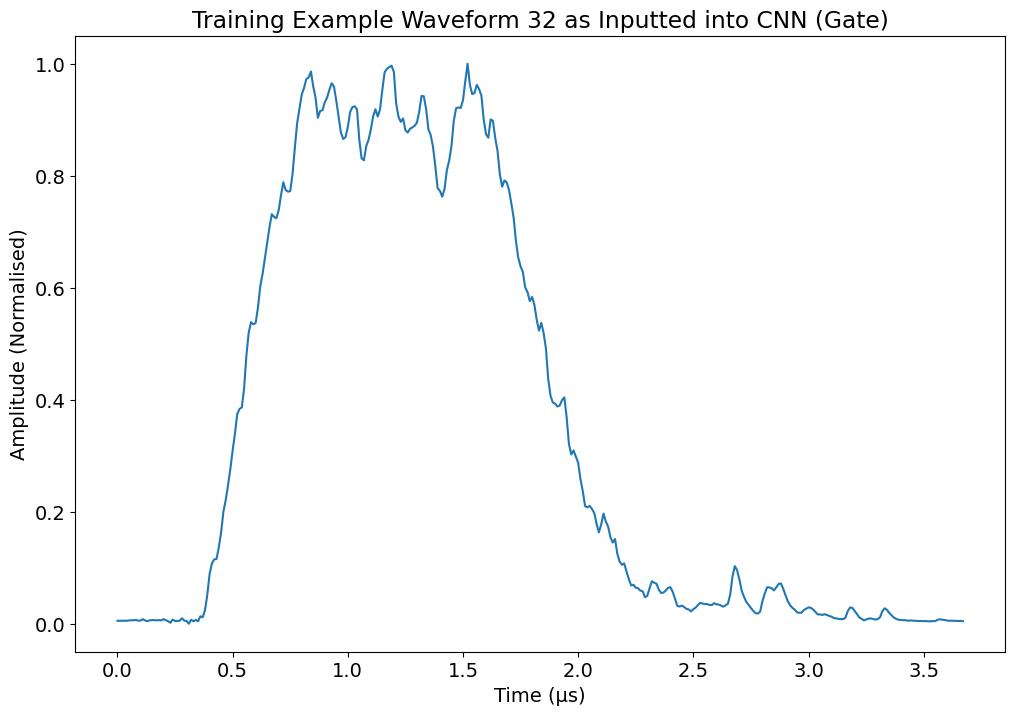

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 2828, 64)          6464      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 1414, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 1414, 154)         591514    
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 707, 154)          0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 108878)            0         
                                                                 
 dense_8 (Dense)             (None, 96)               

In [ ]:
if y_test[sample_index] == 1:
    class_name = "Gate"
elif y_test[sample_index == 2]:
    class_name = "Tritium"
else:
    class_name = "Cathode"
plt.plot(times_us_train[sample_index], normalised_samples_train[sample_index]) # X_train padded is just the reshaped version to change the 2D array into 3D format - the format required for CNN input
# plt.scatter(X_train[0][:2828], X_train[0][2828:])
#plt.plot(arr['times'][0], arr['samples'][0])
# plt.plot(X[0][:1828], X_combined[0][1828:])
plt.ylabel("Amplitude (Normalised)")
plt.xlabel("Time (µs)")
plt.title(f'Training Example Waveform 32 as Inputted into CNN ({class_name})')
plt.show()

print(convoNN.summary())

# ASIDE: RF Code

[[0 0 1]
 [0 1 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 0 1]
 [0 0 1]]


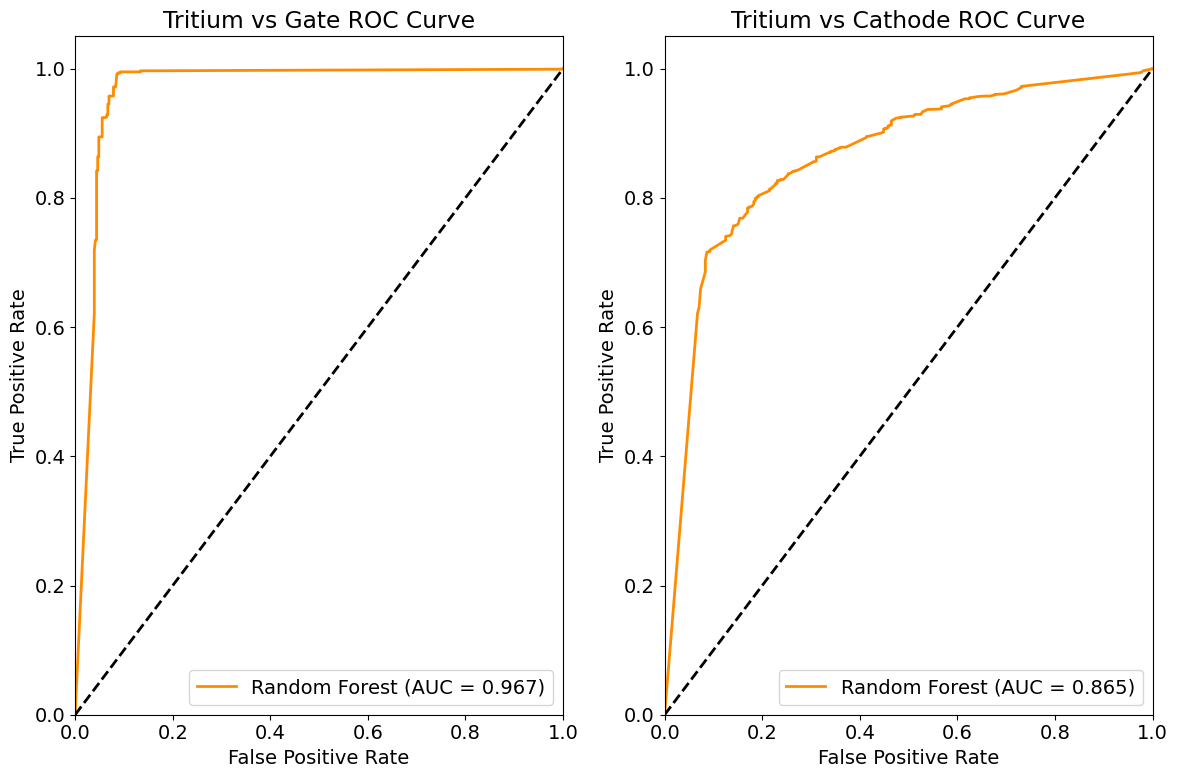

Random Forest accuracy: 0.8535


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Assuming X_train_padded is your CNN input with shape (n_samples, timesteps, 1)
# We need to flatten the waveforms for Random Forest
X_train_flat = X_train_padded.reshape(X_train_padded.shape[0], -1)
X_test_flat = X_test_padded.reshape(X_test_padded.shape[0], -1)

# Create a deliberately suboptimal Random Forest model
# Using few estimators and limiting max_depth will ensure worse performance
rf_model = RandomForestClassifier(
    n_estimators=5,         # Very few trees
    max_depth=3,             # Shallow trees
    min_samples_split=10,    # Conservative splitting
    max_features='sqrt',     # Restricted feature selection
    random_state=42
)

# Train the model
rf_model.fit(X_train_flat, y_train)

# Get predictions
y_pred_proba_rf = rf_model.predict_proba(X_test_flat)

# Create one-hot encoded version of test labels for ROC curve calculation
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
print(y_test_bin)

# Calculate ROC curves for Random Forest
# Binary comparisons
event_pairs = [
    ("Tritium vs Gate", 2, 1),    # Tritium (2) vs Gate (1)
    ("Tritium vs Cathode", 2, 0)  # Tritium (2) vs Cathode (0)
]

# Plot ROC curves
plt.figure(figsize=(12, 8))

for i, (title, class1, class2) in enumerate(event_pairs):
    # Get only the samples belonging to these two classes
    mask = np.logical_or(y_test == class1, y_test == class2)
    # Create binary labels where class1 is the positive class (1)
    binary_true = np.array(y_test[mask] == class1).astype(int)
    
    # Get the probabilities for class1 from samples of these two classes
    # For Random Forest:
    binary_score_rf = y_pred_proba_rf[mask, class1]
    
    # Calculate ROC curve and AUC
    fpr_rf, tpr_rf, _ = roc_curve(binary_true, binary_score_rf)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    
    # Plot
    plt.subplot(1, 2, i+1)
    plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2,
             label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
    
    # Add your CNN ROC curve here using the same approach
    # Assuming y_pred_proba_cnn has the CNN probabilities
    # binary_score_cnn = y_pred_proba_cnn[mask, class1]
    # fpr_cnn, tpr_cnn, _ = roc_curve(binary_true, binary_score_cnn)
    # roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
    # plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2,
    #          label=f'CNN (AUC = {roc_auc_cnn:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} ROC Curve')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print the overall accuracy for reference
rf_accuracy = rf_model.score(X_test_flat, y_test)
print(f"Random Forest accuracy: {rf_accuracy:.4f}")

# If you want to compare with your CNN
# cnn_accuracy = np.mean(np.argmax(y_pred_proba_cnn, axis=1) == y_test)
# print(f"CNN accuracy: {cnn_accuracy:.4f}")